In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import sympy.physics.mechanics as me
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
### Equation of motion for 3D double pendulum ###

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q = me.dynamicsymbols('q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B')  # quaternion
u = me.dynamicsymbols('u1A, u2A, u3A, u1B, u2B, u3B')  # angular velocities
# l, m, g, Ixx, Iyy, Izz = sp.symbols('l m g Ixx Iyy Izz')  # 
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')

N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')

# rotate joint by quaternion and apply angular velocities
# first joint is in the world frame center
A.orient(N, 'Quaternion', [q[0], q[1], q[2], q[3]])
A.set_ang_vel(N, u[0]*A.x + u[1]*A.y + u[2]*A.z)

# set masscenter of the first body
mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

# set the position of the joint between the two bodies
ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)

# orient second body from the first body
B.orient(A, 'Quaternion', [q[4], q[5], q[6], q[7]])
B.set_ang_vel(A, u[3]*B.x + u[4]*B.y + u[5]*B.z)
mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)
I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 200*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 200*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]
kindeq = []

# set kinematic differential equations - see Quaternions and Dynamics, page 9, equation 18
for i in range(2):
    kindeq.append(q[0+i*4].diff(t) - 0.5 * (-u[0+i*3]*q[1+i*4] - u[1+i*3]*q[2+i*4] - u[2+i*3]*q[3+i*4]))
    kindeq.append(q[1+i*4].diff(t) - 0.5 * (u[0+i*3]*q[0+i*4] + u[2+i*3]*q[2+i*4] - u[1+i*3]*q[3+i*4]))
    kindeq.append(q[2+i*4].diff(t) - 0.5 * (u[1+i*3]*q[0+i*4] - u[2+i*3]*q[1+i*4] + u[0+i*3]*q[3+i*4]))
    kindeq.append(q[3+i*4].diff(t) - 0.5 * (u[2+i*3]*q[0+i*4] + u[1+i*3]*q[1+i*4] - u[0+i*3]*q[2+i*4]))

eoms_cnst = sp.Matrix([[q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2 - 1], 
                       [q[4]**2 + q[5]**2 + q[6]**2 + q[7]**2 - 1]])
KM = me.KanesMethod(N, q_ind=q, u_ind=u, kd_eqs=kindeq)
(fr, frstar) = KM.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [3]:
sp.shape(frstar)

(6, 1)

In [4]:
eoms = sp.Matrix(kindeq).col_join(fr+frstar)

In [5]:
# duration = 2 # seconds
# num_nodes = 21
# interval_value = duration/(num_nodes - 1)
# time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
# obj_func = sp.Integral(sum(sp.Matrix(F).applyfunc(lambda e: e**2)),t)
# obj, obj_grad = create_objective_function(obj_func,
#                                           state_symbols,
#                                           specified_symbols,
#                                           tuple(),
#                                           num_nodes,
#                                           interval_value)
# obj_func

In [7]:
import opty_lib as op
import optyEngine as oe
reload (oe);
reload (op);
duration = 1.5
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)
eul_traj,deul_traj = oe.create_trajectory(num_nodes,duration,interval_value)
quat_traj,quat_traj_guess,_,_ = oe.eul2quat_traj(num_nodes,eul_traj,interval_value)

quat_traj_glob = quat_traj[:quat_traj.size//2]
numcoords = str(num_nodes+1)
q0A = sp.symbols('q0A1:'+numcoords)
q1A = sp.symbols('q1A1:'+numcoords)
q2A = sp.symbols('q2A1:'+numcoords)
q3A = sp.symbols('q3A1:'+numcoords)
q0B = sp.symbols('q0B1:'+numcoords)
q1B = sp.symbols('q1B1:'+numcoords)
q2B = sp.symbols('q2B1:'+numcoords)
q3B = sp.symbols('q3B1:'+numcoords)

sym_vec = sp.Matrix(q0A+q1A+q2A+q3A+q0B+q1B+q2B+q3B)
print(len(sym_vec))
print(len(quat_traj_glob))

# objective_np, objective_jac_np = op.min_rotglob(sym_vec, quat_traj_glob, num_nodes, interval_value)

808
404


In [8]:
import optyEngine as oe
reload (oe);
eul_traj,deul_traj = oe.create_trajectory(num_nodes,duration,interval_value)
quat_traj,quat_traj_guess,_,_ = oe.eul2quat_traj(num_nodes,eul_traj,interval_value)

def obj(free):
    min_traj = interval_value * np.sum((quat_traj_guess[:4*2*num_nodes] - free[:4*2*num_nodes])**2)
    # min_traj = objective_np(*free[:4*2*num_nodes])
    # min_vel = 0.005*interval_value * np.sum((quat_traj_guess[4*2*num_nodes:7*2*num_nodes] - free[4*2*num_nodes:7*2*num_nodes])**2)
    min_torque = 0.001 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:4*2*num_nodes] = 2.0 * interval_value * (free[:4*2*num_nodes] - quat_traj_guess[:4*2*num_nodes])
    # grad[:4*2*num_nodes] = objective_jac_np(*free[:4*2*num_nodes])[0,:]
    # grad[4*2*num_nodes:7*2*num_nodes] = 0.005 * 2.0 * interval_value * (free[4*2*num_nodes:7*2*num_nodes] - quat_traj_guess[4*2*num_nodes:7*2*num_nodes])
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 0.001 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [9]:
instance_constraints = [
    q[0].func(0.0) - 1,
    q[1].func(0.0) - 0,
    q[2].func(0.0) - 0,
    q[3].func(0.0) - 0,
    q[4].func(0.0) - 1,
    q[5].func(0.0) - 0,
    q[6].func(0.0) - 0,
    q[7].func(0.0) - 0,
    u[0].func(0.0) - 0,
    u[1].func(0.0) - 0,
    u[2].func(0.0) - 0,
    u[3].func(0.0) - 0,
    u[4].func(0.0) - 0,
    u[5].func(0.0) - 0,
]

for i in time:
    normQ1 = q[0].func(i)**2+q[1].func(i)**2+q[2].func(i)**2+q[3].func(i)**2-1
    normQ2 = q[4].func(i)**2+q[5].func(i)**2+q[6].func(i)**2+q[7].func(i)**2-1
    instance_constraints.append(normQ1)
    instance_constraints.append(normQ2)
instance_constraints = tuple(instance_constraints)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [10]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds={},
               integration_method='midpoint') # 

prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)

KeyboardInterrupt: 

In [29]:
# initial_guess = np.zeros(prob.num_free)
initial_guess = np.random.randn(prob.num_free)*0
initial_guess[:7*2*num_nodes] = quat_traj_guess
prob.add_option('max_iter',10000)
# prob.add_option('acceptable_tol', 1e-12)
# prob.add_option('tol', 1e-12)

In [30]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)

print(info['status_msg'])
print(info['obj_val'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    56822
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2020
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1616
Total number of inequality c

[[ 0.00000000e+00 -1.27296295e-07 -2.75018064e-06 -1.66970734e-05
  -5.74992491e-05 -1.46537678e-04 -3.10349679e-04 -5.80082335e-04
  -9.91035472e-04 -1.58223911e-03 -2.39601923e-03 -3.47751753e-03
  -4.87414318e-03 -6.63494634e-03 -8.80991274e-03 -1.14491869e-02
  -1.46022374e-02 -1.83169821e-02 -2.26388935e-02 -2.76101055e-02
  -3.32685444e-02 -3.96471037e-02 -4.67728828e-02 -5.46665080e-02
  -6.33415496e-02 -7.28040491e-02 -8.30521663e-02 -9.40759541e-02
  -1.05857267e-01 -1.18369804e-01 -1.31579290e-01 -1.45443786e-01
  -1.59914134e-01 -1.74934518e-01 -1.90443137e-01 -2.06372977e-01
  -2.22652657e-01 -2.39207349e-01 -2.55959730e-01 -2.72830956e-01
  -2.89741641e-01 -3.06612802e-01 -3.23366761e-01 -3.39927986e-01
  -3.56223836e-01 -3.72185226e-01 -3.87747172e-01 -4.02849228e-01
  -4.17435808e-01 -4.31456392e-01 -4.44865621e-01 -4.57623297e-01
  -4.69694277e-01 -4.81048300e-01 -4.91659730e-01 -5.01507251e-01
  -5.10573518e-01 -5.18844768e-01 -5.26310420e-01 -5.32962666e-01
  -5.38796

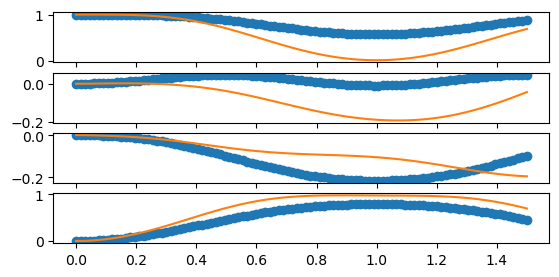

In [31]:
import opty_lib as op
import optyEngine as oe
reload (oe);
reload (op);

op.plot_results(solution, quat_traj_glob, time, num_nodes)

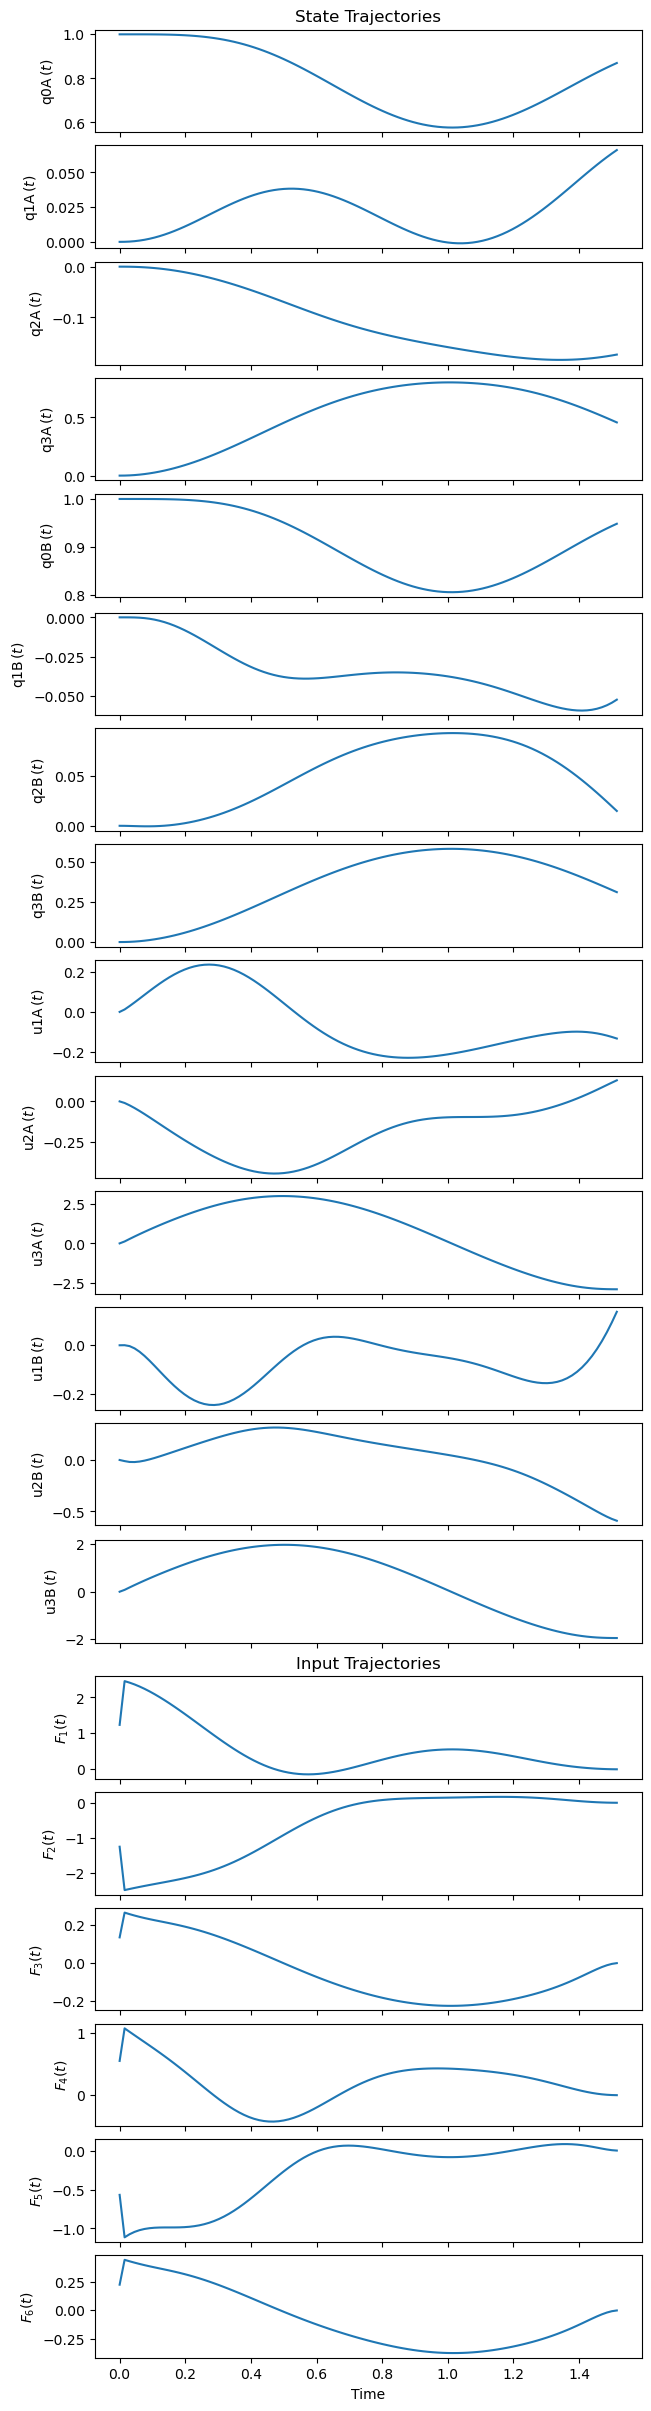

In [32]:
fig, axes = plt.subplots(20, 1, sharex=True,
                         figsize=(6.4, 0.8*30),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

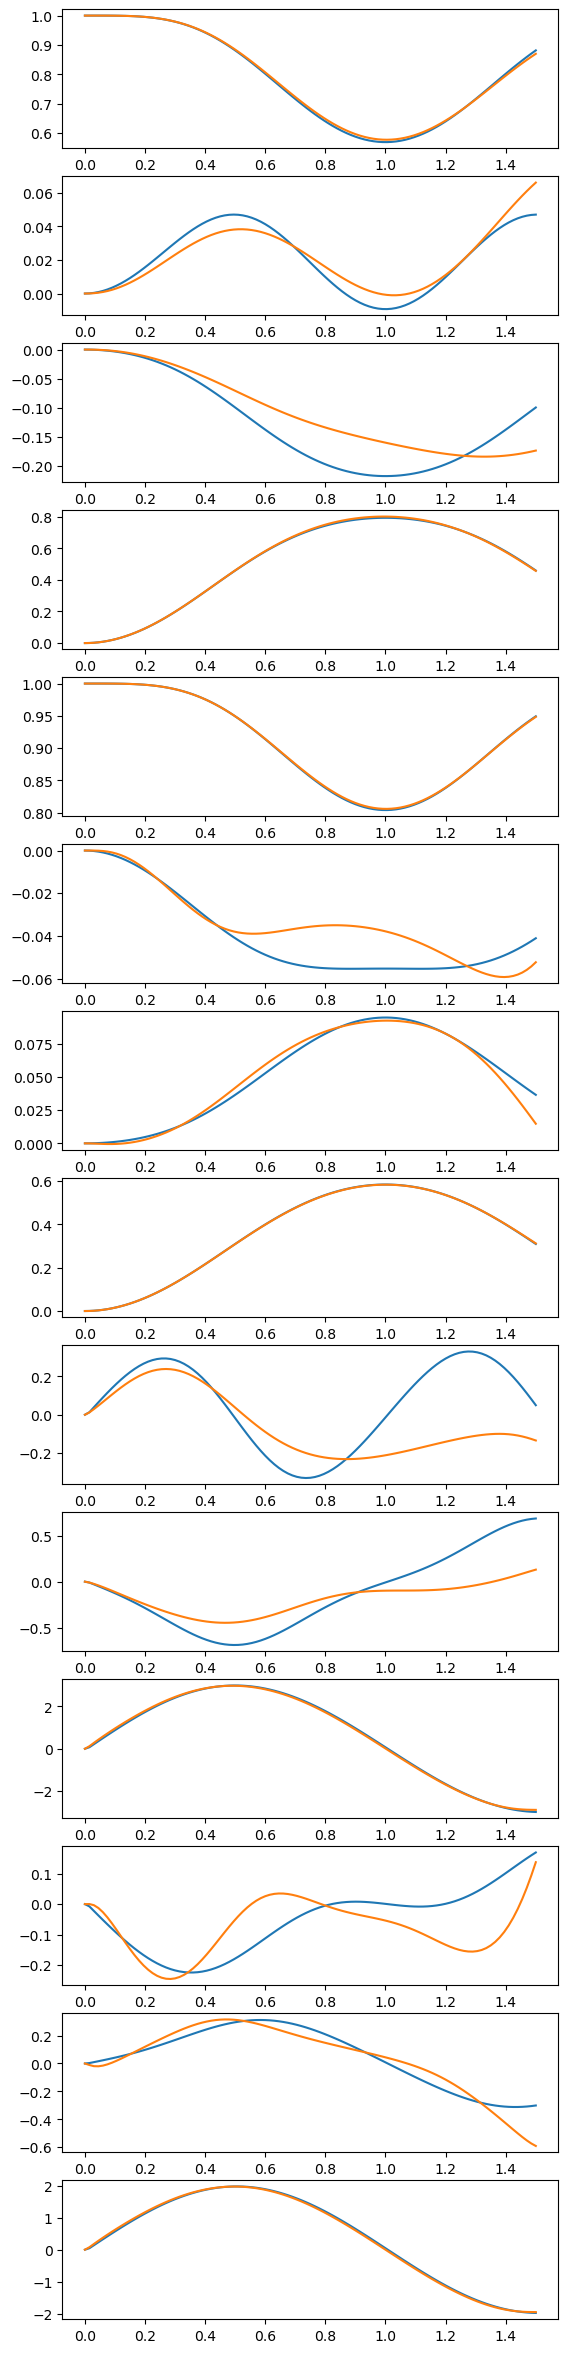

In [33]:
fig, axs = plt.subplots(14)
for j in range(14):
    axs[j].plot(time,quat_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(30)